In [16]:
!pip install -r ../requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


In [17]:
import sys
import os

sys.path.append(os.path.abspath('root/deepfashion-image-classification/src'))

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from data.v2.dataset import DeepFashionDataset

import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Load and preprocess data

In [19]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

In [20]:
train_transform = T.Compose([
    T.ToImage(),
    T.Resize((processor.size['height'], processor.size['width'])),
    T.RandomCrop((processor.size['height'], processor.size['width'])),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1,0.1)),
    T.RandomRotation(15),
    T.GaussianBlur(kernel_size=3),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = T.Compose([
    T.ToImage(),
    T.Resize((processor.size['height'], processor.size['width'])),
    T.CenterCrop((processor.size['height'], processor.size['width'])),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=processor.image_mean, std=processor.image_std)
])

In [21]:
include_labels = [
    'Jumpsuit', 'Top', 'Bomber', 'Skirt', 'Tee', 'Sweatpants', 'Flannel', 'Tank', 'Turtleneck', 
    'Jersey', 'Blouse', 'Kaftan', 'Jeggings', 'Shirtdress', 'Sarong', 'Jacket', 'Leggings', 
    'Nightdress', 'Sweatshorts', 'Coverup' ]
train_dataset = DeepFashionDataset(split='train', transform=train_transform, downsample=True, max_samples_per_class=500, include_labels=include_labels)
val_dataset = DeepFashionDataset(split='val', transform=val_transform, include_labels=include_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9058825].


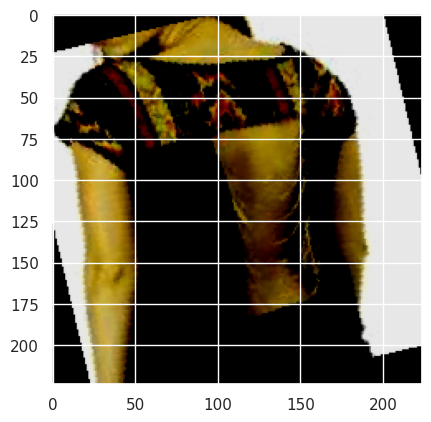

In [22]:
plt.imshow(np.transpose(train_dataset[2][0], (1, 2, 0)))

# Set Up the ViT Model

In [23]:
num_classes = len(train_dataset.classes)

In [24]:
num_classes

20

In [25]:
"""
ignore_mismatched_sizes = True
Whether or not to raise an error if some of the weights from the checkpoint do not have the same 
size as the weights of the model (if for instance, you are instantiating a model with 10 labels 
from a checkpoint with 3 labels)
"""
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # allows head resizing
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# MAP LABELS
model.config.id2label = {i: label for i, label in enumerate(train_dataset.classes)}
model.config.label2id = {label: i for i, label in enumerate(train_dataset.classes)}

# Train the model

In [27]:
class HFDatasetWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {
            "pixel_values": image,
            "labels": label
        }

In [28]:
train_hf_dataset = HFDatasetWrapper(train_dataset)
val_hf_dataset = HFDatasetWrapper(val_dataset)

In [29]:
print(len(train_hf_dataset), len(val_hf_dataset))

7385 1930


In [30]:
training_args = TrainingArguments(
    output_dir='../experiments/sanity/',
    overwrite_output_dir=True,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2, # save last
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_strategy='epoch',
    load_best_model_at_end=True, # save best
    metric_for_best_model='loss'
)


In [31]:
accuracy = evaluate.load('accuracy')
recall = evaluate.load('recall')
precision = evaluate.load('precision')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy.compute(predictions=predictions, references=labels)
    # rec = recall.compute(predictions=predictions, references=labels, average='macro')
    # prec = precision.compute(predictions=predictions, references=labels, average='macro')
    
    # return {
    #     "accuracy": acc["accuracy"],
    #     "recall": rec["recall"],
    #     "precision": prec["precision"]
    # }
    return acc

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf_dataset,
    eval_dataset=val_hf_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)
trainer.train()
log_history = trainer.state.log_history


Epoch,Training Loss,Validation Loss,Accuracy
1,1.445300,1.032869,0.692746
2,0.954900,0.882190,0.734197
3,0.732600,0.881881,0.735233
4,0.545200,0.931914,0.721244


In [33]:
log_history[:-1]

[{'loss': 1.4453,
  'grad_norm': 11.339591026306152,
  'learning_rate': 4.002164502164502e-05,
  'epoch': 1.0,
  'step': 462},
 {'eval_loss': 1.03286874294281,
  'eval_accuracy': 0.6927461139896373,
  'eval_runtime': 6.079,
  'eval_samples_per_second': 317.484,
  'eval_steps_per_second': 19.904,
  'epoch': 1.0,
  'step': 462},
 {'loss': 0.9549,
  'grad_norm': 10.7860746383667,
  'learning_rate': 3.0021645021645023e-05,
  'epoch': 2.0,
  'step': 924},
 {'eval_loss': 0.8821896910667419,
  'eval_accuracy': 0.7341968911917098,
  'eval_runtime': 5.871,
  'eval_samples_per_second': 328.737,
  'eval_steps_per_second': 20.61,
  'epoch': 2.0,
  'step': 924},
 {'loss': 0.7326,
  'grad_norm': 11.922965049743652,
  'learning_rate': 2.002164502164502e-05,
  'epoch': 3.0,
  'step': 1386},
 {'eval_loss': 0.8818811774253845,
  'eval_accuracy': 0.7352331606217617,
  'eval_runtime': 5.9022,
  'eval_samples_per_second': 326.999,
  'eval_steps_per_second': 20.501,
  'epoch': 3.0,
  'step': 1386},
 {'loss'

# Evaluation / Inference

In [34]:
model.eval()
all_preds = []
all_true = []

val_loader = DataLoader(val_hf_dataset, batch_size=16, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("Evaluating on CUDA")

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating..."):
        X_val = batch['pixel_values'].to(device)
        y_val = batch['labels'].to(device)

        outputs = model(pixel_values=X_val)
        preds = outputs.logits.argmax(dim=1)
        all_preds.extend(preds.cpu())
        all_true.extend(y_val.cpu())

Evaluating on CUDA


Validating...: 100%|██████████| 121/121 [00:05<00:00, 20.54it/s]


In [35]:
# for output: replace indices with actual names
label_true_named = [model.config.id2label.get(i.item(), str(i.item())) for i in all_true]
label_pred_named = [model.config.id2label.get(i.item(), str(i.item())) for i in all_preds]
print(classification_report(label_true_named, label_pred_named))

              precision    recall  f1-score   support

      Blouse       0.52      0.64      0.57        53
      Bomber       0.56      0.60      0.58       156
     Coverup       0.56      0.59      0.57        17
     Flannel       0.63      0.49      0.55        85
      Jacket       0.49      0.71      0.58        24
    Jeggings       0.86      0.83      0.85        53
      Jersey       0.52      0.52      0.52        60
    Jumpsuit       0.95      0.90      0.92       589
      Kaftan       0.56      0.77      0.65        47
    Leggings       0.60      0.75      0.67        24
  Nightdress       0.44      0.52      0.48        21
      Sarong       0.84      0.84      0.84        32
  Shirtdress       0.64      0.85      0.73        54
       Skirt       0.90      0.87      0.89       118
  Sweatpants       0.94      0.95      0.94       112
 Sweatshorts       0.67      0.59      0.62        17
        Tank       0.61      0.68      0.65        75
         Tee       0.57    

Text(0.5, 1.0, 'Confusion Matrix')

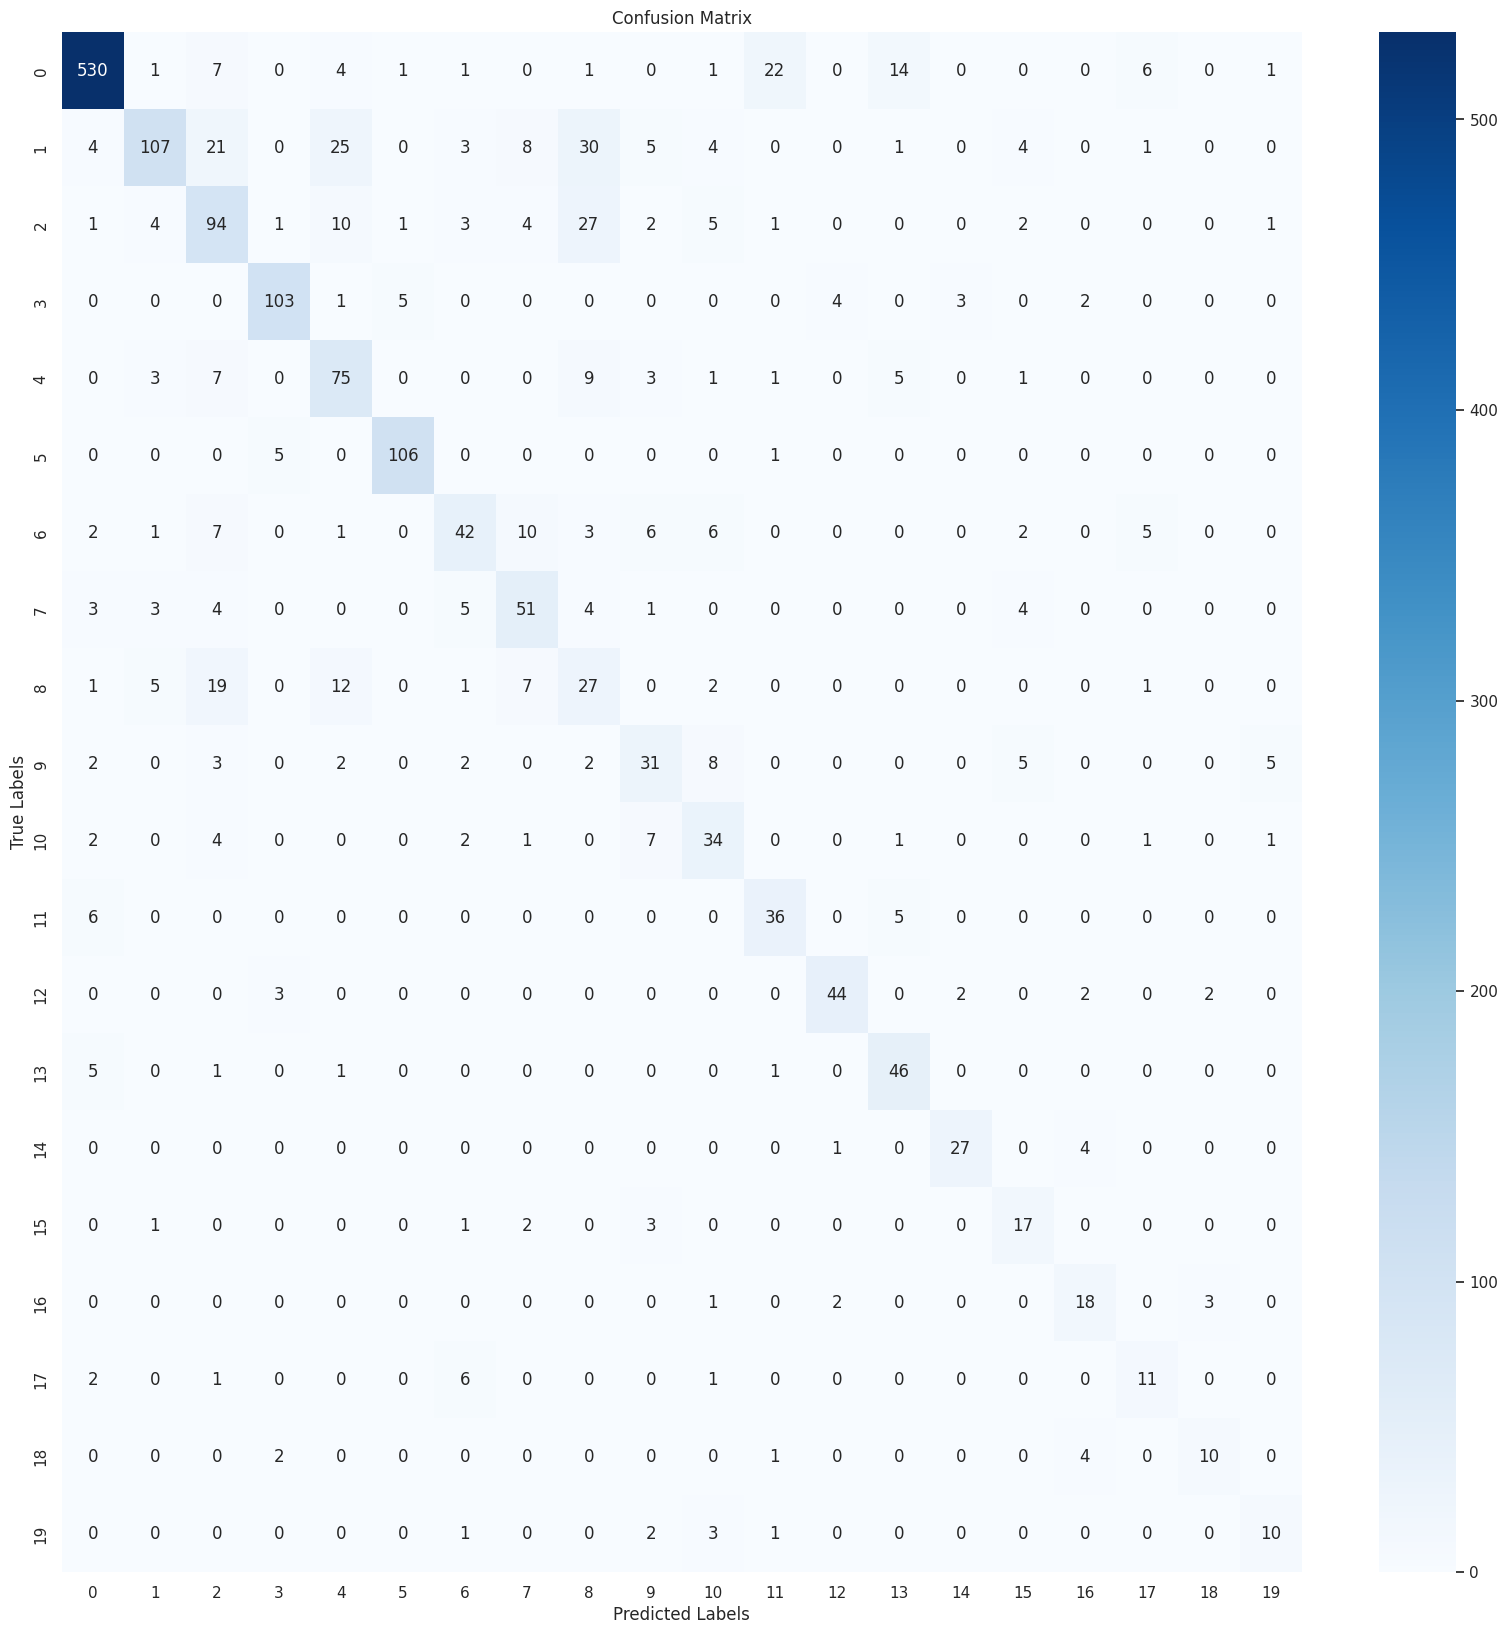

In [36]:
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(all_true, all_preds), 
            annot=True, fmt='g', cmap='Blues') 
            # xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
# plt.xticks(rotation=90)
# plt.yticks(rotation=90)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

## Single Image

In [41]:
image = Image.open('root/deepfashion-image-classification/testimg1.png').convert("RGB")
image = val_transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=image)
    pred = outputs.logits.argmax(dim=1).item()

pred_label = model.config.id2label[pred]
# print(f"Predicted Class: {pred_label}")
model.config.id2label


{0: 'Jumpsuit',
 1: 'Top',
 2: 'Bomber',
 3: 'Skirt',
 4: 'Tee',
 5: 'Sweatpants',
 6: 'Flannel',
 7: 'Tank',
 8: 'Turtleneck',
 9: 'Jersey',
 10: 'Blouse',
 11: 'Kaftan',
 12: 'Jeggings',
 13: 'Shirtdress',
 14: 'Sarong',
 15: 'Jacket',
 16: 'Leggings',
 17: 'Nightdress',
 18: 'Sweatshorts',
 19: 'Coverup'}

Top 5: ['Top' 'Tee' 'Turtleneck' 'Jacket' 'Bomber']


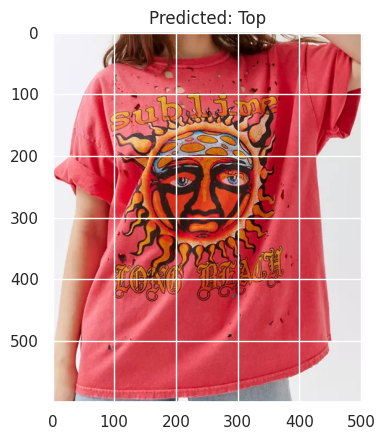

In [40]:
plt.imshow(Image.open('root/deepfashion-image-classification/testimg1.png'))
plt.title(f"Predicted: {pred_label}")
_, top5_idx = torch.topk(outputs.logits, 5)
print(f'Top 5: {np.array(val_dataset.classes)[top5_idx[0].cpu()]}')

In [44]:
image = Image.open('root/deepfashion-image-classification/testimg2.png').convert("RGB")
image = val_transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=image)
    pred = outputs.logits.argmax(dim=1).item()

pred_label = model.config.id2label[pred]
# print(f"Predicted Class: {pred_label}")


Top 5: ['Tee' 'Turtleneck' 'Bomber' 'Blouse' 'Top']


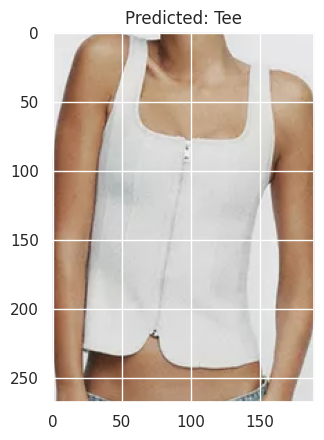

In [45]:
plt.imshow(Image.open('root/deepfashion-image-classification/testimg2.png'))
plt.title(f"Predicted: {pred_label}")
_, top5_idx = torch.topk(outputs.logits, 5)
print(f'Top 5: {np.array(val_dataset.classes)[top5_idx[0].cpu()]}')

In [47]:
image = Image.open('root/deepfashion-image-classification/testimg3.png').convert("RGB")
image = val_transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=image)
    pred = outputs.logits.argmax(dim=1).item()

pred_label = model.config.id2label[pred]
# print(f"Predicted Class: {pred_label}")

Top 5: ['Jeggings' 'Leggings' 'Skirt' 'Sweatshorts' 'Sarong']


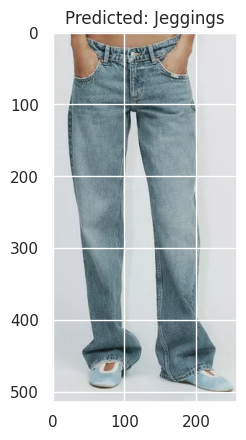

In [48]:
plt.imshow(Image.open('root/deepfashion-image-classification/testimg3.png'))
plt.title(f"Predicted: {pred_label}")
_, top5_idx = torch.topk(outputs.logits, 5)
print(f'Top 5: {np.array(val_dataset.classes)[top5_idx[0].cpu()]}')